### The Goal

The goal of your project is to query the database to get the data needed to perform a statistical analysis. In this statistical analysis, we'll need to perform a hypothesis test (or perhaps several) to answer the following questions:

##### Question : Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?


![](Northwind_ERD.png)

In [1]:
# Importing libraries
import sqlite3 # for database
import pandas as pd # for dataframe
import matplotlib.pyplot as plt # plotting
import seaborn as sns # plotting
import numpy as np # analysis
from scipy import stats # significance levels, normality
from scipy.stats import ttest_ind
import itertools # for combinations
import statsmodels.api as sm # anova
from statsmodels.formula.api import ols
sns.set_style('whitegrid')
plt.style.use('ggplot')
#plt.xkcd();
import warnings
warnings.filterwarnings('ignore') # hide matplotlib warnings

In [2]:
# Connecting to database
conn = sqlite3.connect('Northwind_small.sqlite')
c = conn.cursor()

### Initial Exploratory Data Analysis - EDA:

In [3]:
c.execute('''SELECT name as NAME FROM sqlite_master WHERE type='table';''')
df = pd.DataFrame(c.fetchall()) #Take results and create dataframe
df.columns = [i[0] for i in c.description]
df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12
NAME,Employee,Category,Customer,Shipper,Supplier,Order,Product,OrderDetail,CustomerCustomerDemo,CustomerDemographic,Region,Territory,EmployeeTerritory


In [4]:
c.execute('''SELECT *
              FROM Employee;''')
df = pd.DataFrame(c.fetchall()) #Take results and create dataframe
df.columns = [i[0] for i in c.description]
print(df.columns)
print(df['Country'].unique())
#df.head(3)

Index(['Id', 'LastName', 'FirstName', 'Title', 'TitleOfCourtesy', 'BirthDate',
       'HireDate', 'Address', 'City', 'Region', 'PostalCode', 'Country',
       'HomePhone', 'Extension', 'Photo', 'Notes', 'ReportsTo', 'PhotoPath'],
      dtype='object')
['USA' 'UK']


In [5]:
c.execute('''SELECT *
              FROM Category;''')
df = pd.DataFrame(c.fetchall()) #Take results and create dataframe
df.columns = [i[0] for i in c.description]

print(df['Id'].unique())
print(df['CategoryName'].unique())
df.T

[1 2 3 4 5 6 7 8]
['Beverages' 'Condiments' 'Confections' 'Dairy Products' 'Grains/Cereals'
 'Meat/Poultry' 'Produce' 'Seafood']


,0,1,2,3,4,5,6,7
Id,1,2,3,4,5,6,7,8
CategoryName,Beverages,Condiments,Confections,Dairy Products,Grains/Cereals,Meat/Poultry,Produce,Seafood
Description,"Soft drinks, coffees, teas, beers, and ales","Sweet and savory sauces, relishes, spreads, an...","Desserts, candies, and sweet breads",Cheeses,"Breads, crackers, pasta, and cereal",Prepared meats,Dried fruit and bean curd,Seaweed and fish


In [6]:
c.execute('''SELECT *
              FROM Product;''')
df = pd.DataFrame(c.fetchall()) #Take results and create dataframe
df.columns = [i[0] for i in c.description]
print(' There are ', df['ProductName'].count(), 'product names')
# print(df['ProductName'].unique())
# df.head(3)
# df.tail(3)


 There are  77 product names


In [7]:
c.execute('''SELECT *
              FROM OrderDetail;''')
df = pd.DataFrame(c.fetchall()) # Create dataframe
df.columns = [i[0] for i in c.description]
product_id = np.sort(df['ProductId'].unique())
print('There are ', len(product_id), 'product id')
df_D_P = df.groupby(['Discount']).sum().iloc[:, 3:4]
print('There are ', len(df_D_P), 'discount levels which includes 0% discount')
df_D_P.T

There are  77 product id
There are  11 discount levels which includes 0% discount


Discount,0.0,0.01,0.02,0.03,0.04,0.05,0.06,0.1,0.15,0.2,0.25
Quantity,28599,2,4,5,1,5182,2,4366,4456,4351,4349


In [8]:
c.execute('''SELECT *
              FROM Supplier;''')
df = pd.DataFrame(c.fetchall()) #Take results and create dataframe
df.columns = [i[0] for i in c.description]
df.describe(include=['object', 'bool'])


,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,HomePage
count,29,29,29,29,29,29,29,29,29,13,5
unique,29,29,15,29,29,11,29,16,29,13,5
top,"Pavlova, Ltd.",Niels Petersen,Sales Representative,"471 Serangoon Loop, Suite #402",Osaka,North America,27478,USA,85.57.00.07,(12345) 1210,#FORMAGGI.HTM#
freq,1,1,6,1,1,6,1,4,1,1,1


In [9]:
# query all order detail with employee info
c.execute('''
            SELECT E.Country, E.ID AS SalePersonID, 
            (E.FirstName || ' ' || E.LastName) AS SalePerson,
            OD.ProductID, OD.Discount, OD.Quantity
            FROM Employee AS E
            INNER JOIN 'Order' AS O ON E.ID=O.EmployeeID
            INNER JOIN OrderDetail AS OD ON O.ID=OD.OrderID
          ''')
empl_sale_df = pd.DataFrame(c.fetchall())
empl_sale_df.columns = [i[0] for i in c.description]
sale_employee_country = empl_sale_df.groupby(['Country', 'SalePerson'])\
                                    .sum().iloc[:, 3:4]
sale_employee_country.T

Country                UK                                             \
SalePerson Anne Dodsworth Michael Suyama Robert King Steven Buchanan   
Quantity             2670           3527        4654            3036   

Country              USA                                                  \
SalePerson Andrew Fuller Janet Leverling Laura Callahan Margaret Peacock   
Quantity            6055            7852           5913             9798   

Country                   
SalePerson Nancy Davolio  
Quantity            7812

            0     1     2     3     4     5      6     7     8     9     10  \
Country     UK    UK    UK    UK    UK    UK    USA   USA   USA   USA   USA   
Discount     0  0.05   0.1  0.15   0.2  0.25      0  0.01  0.02  0.03  0.04   
Quantity  6792  1510  1428  1412  1200  1545  21807     2     4     5     1   

            11    12    13    14    15    16  
Country    USA   USA   USA   USA   USA   USA  
Discount  0.05  0.06   0.1  0.15   0.2  0.25  
Quantity  3672     2  2938  3044  3151  2804  


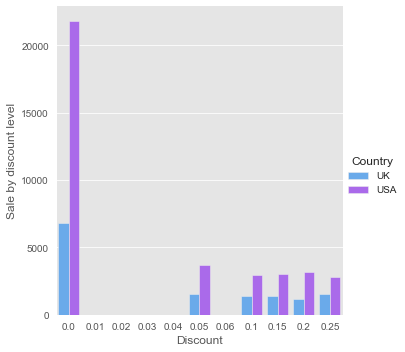

In [10]:
# group employee sale details by employee country and discount to calculate sum of sale quantity
empl_sale_df1 = empl_sale_df.groupby(['Country', 'Discount']).sum()
empl_sale_df1.drop(columns=['ProductId', 'SalePersonID'], inplace=True)
empl_sale_df1.reset_index(inplace=True)
print(empl_sale_df1.T)

# plot
g = sns.catplot(data=empl_sale_df1, x='Discount',
                y='Quantity', hue='Country', kind="bar", palette='cool')
g.set_ylabels("Sale by discount level");

         SalePerson  SalePersonID  Quantity
0     Andrew Fuller             2      6055
1    Anne Dodsworth             9      2670
2   Janet Leverling             3      7852
3    Laura Callahan             8      5913
4  Margaret Peacock             4      9798
5    Michael Suyama             6      3527
6     Nancy Davolio             1      7812
7       Robert King             7      4654
8   Steven Buchanan             5      3036


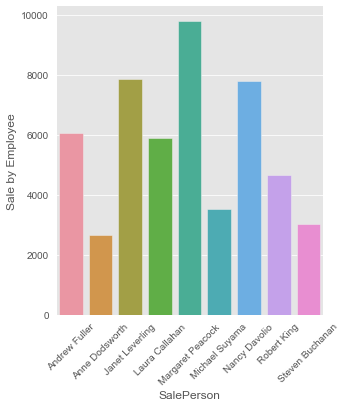

In [11]:
# group employee sale details by employee to calculate sum of sale quantity
empl_sale_df2 = empl_sale_df.groupby(['SalePerson', 'SalePersonID']).sum()
empl_sale_df2.drop(columns=['ProductId', 'Discount'], inplace=True)
empl_sale_df2.reset_index(inplace=True)
print(empl_sale_df2)

# plot
g = sns.catplot(data=empl_sale_df2, x='SalePerson', y='Quantity', kind="bar")
g.set_ylabels("Sale by Employee")
g.set_xticklabels(rotation=45);

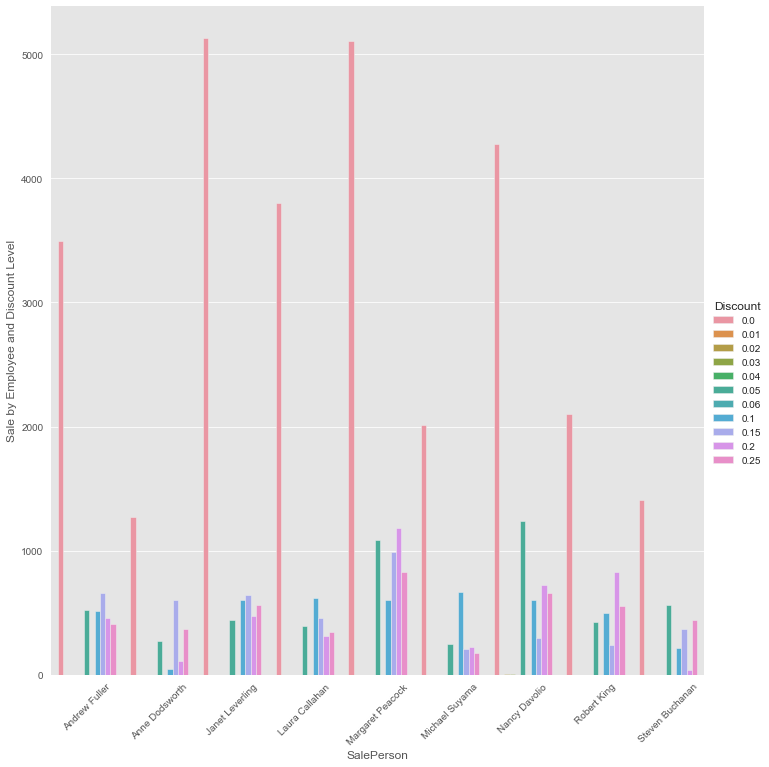

In [12]:
# group employee sale details by employee and discount to calculate sum of sale quantity
empl_sale_df3 = empl_sale_df.groupby(['SalePerson', 'Discount']).sum()
empl_sale_df3.drop(columns=['ProductId'], inplace=True)
empl_sale_df3.reset_index(inplace=True)

# plot
g = sns.catplot(data=empl_sale_df3, x='SalePerson', y='Quantity',
                           hue='Discount', kind="bar", height=10)
g.set_ylabels("Sale by Employee and Discount Level")
g.set_xticklabels(rotation=45);

### LOAD FROM DATABASE TABLES TO DATAFRAMES 

In [13]:
c.execute('''SELECT name as NAME FROM sqlite_master WHERE type='table';''')
df = pd.DataFrame(c.fetchall())
df[:][0]

df_all = []
for i in df[:][0]:
    table = c.execute('select * from "'+i+'"').fetchall()
    # for table i, get the metadata of table i
    columns = c.execute('PRAGMA table_info("'+i+'")').fetchall() 
    # use table column names as the dataframe column names   
    df = pd.DataFrame(table, columns=[i[1] for i in columns]) 
    df_name = i+"_df" # Assign name for each table
    exec(df_name + " = df") # => TableName_df
    # store all dataframe names in the list
    df_all.append(df_name)
    #try : Product_df, OrderDetail_df, etc.
print(df_all)


['Employee_df', 'Category_df', 'Customer_df', 'Shipper_df', 'Supplier_df', 'Order_df', 'Product_df', 'OrderDetail_df', 'CustomerCustomerDemo_df', 'CustomerDemographic_df', 'Region_df', 'Territory_df', 'EmployeeTerritory_df']


In [14]:
# Supplier_df['CompanyName'].unique()    # Total: 29 CompanyName
# Supplier_df['Id'].unique()             # Total: 29
print('There are ', len(Supplier_df), 'suppliers')

There are  29 suppliers


### Exploratory Data Analysis - EDA:

Order quantities of discounted and not discounted products

Table Product has 77 entries, each entry is unique product

First we can check visually to see if discount really made a difference in product quantity of order


In [15]:
OrderDetail_df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [16]:
OrderDetail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB


In [17]:
OrderDetail_df.isnull().sum()

Id           0
OrderId      0
ProductId    0
UnitPrice    0
Quantity     0
Discount     0
dtype: int64

In [18]:
OrderDetail_df.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167
std,241.378032,22.159019,29.827418,19.022047,0.083450
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


In [19]:
# Create new feature in dataframe.
OrderDetail_df['Discount_code'] = OrderDetail_df['Discount'].apply\
                                                 (lambda row: 'D' if row!=0 else 'N')
OrderDetail_df.head()
#OrderDetail_df.info()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Discount_code
0,10248/11,10248,11,14.0,12,0.0,N
1,10248/42,10248,42,9.8,10,0.0,N
2,10248/72,10248,72,34.8,5,0.0,N
3,10249/14,10249,14,18.6,9,0.0,N
4,10249/51,10249,51,42.4,40,0.0,N


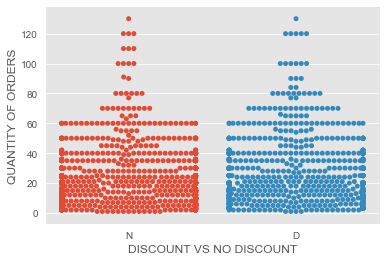

* There is not much different between quantity of orders distribution between with or without discount program. We cannot say any thing about this


In [20]:
# Make bee swarm plot
_ = sns.swarmplot(x='Discount_code', y='Quantity', data=OrderDetail_df)
plt.margins = 0.02

# Label axes
_ = plt.xlabel('DISCOUNT VS NO DISCOUNT')
_ = plt.ylabel('QUANTITY OF ORDERS')

# Show the plot
plt.show()

print('* There is not much different between quantity of orders distribution \
between with or without discount program. We cannot say any thing about this')

### Let's check the ECDFs of two groups of data:
##### Discount vs No_discount by Product Id.

In [21]:
def ecdf (data):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1,(n+1))/n
    return x, y

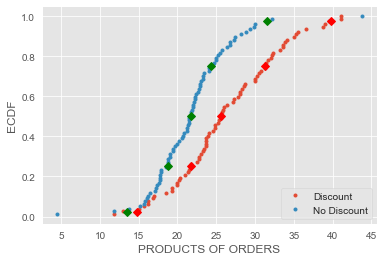

In [22]:
discount    = OrderDetail_df[OrderDetail_df['Discount']!=0].\
                      groupby('ProductId')['Quantity'].mean()
no_discount = OrderDetail_df[OrderDetail_df['Discount']==0].\
                      groupby('ProductId')['Quantity'].mean()
discount_a = np.array(discount)
no_discount_a = np.array(no_discount)

x_discount, y_discount = ecdf(discount_a)
x_no_discount, y_no_discount = ecdf(no_discount_a)

# Specify array of percentiles
percentiles = np.array([2.5, 25, 50, 75, 97.5])
ptiles_discount = np.percentile(discount_a, percentiles)
ptiles_no_discount = np.percentile(no_discount_a, percentiles)
# Plot all ECDFs on the same plot:
_=plt.plot(x_discount, y_discount, marker = '.', linestyle = 'none')
_=plt.plot(x_no_discount, y_no_discount, marker = '.', linestyle = 'none')
_=plt.plot(ptiles_discount, percentiles/100, marker = 'D', \
                                color = 'red', linestyle = 'none')
_=plt.plot(ptiles_no_discount, percentiles/100, marker = 'D', \
                                color = 'green', linestyle = 'none')
# Annotate the plot:
_=plt.legend(('Discount', 'No Discount'), loc = 'lower right')
_=plt.xlabel('PRODUCTS OF ORDERS')
_=plt.ylabel('ECDF')
plt.show()

##### At the 50 percentile:
* we have the mean of product quantity of orders by discount is around 27 items per order
* we have the mean of product quantity of orders by no discount is around 21 items per order. (we will have precisely number as below)

*** (ECDF chart : y - value is the fraction of data points that have a value smaller than the corresponding x -value)

large_num_percentage =  70.13 %
discount_mean =  27.11 items per order
no_discount_mean =  21.72 items per order
mean_diff =  5.39


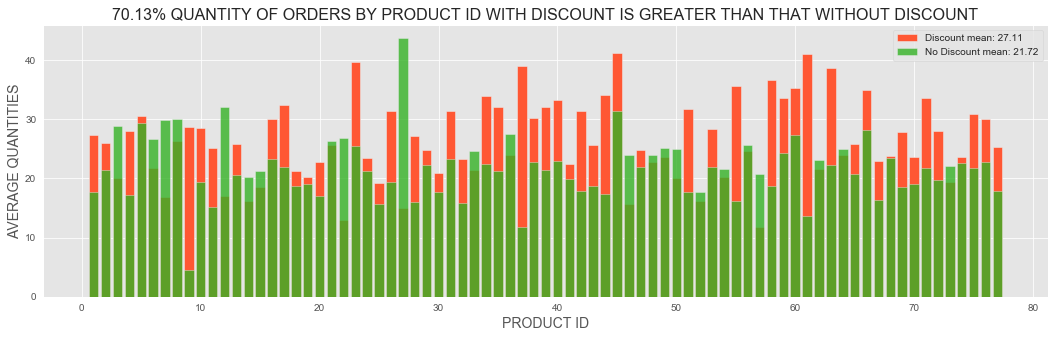

In [23]:
# Percentage of quantity of orders with discount which are larger than
#that with no discount.
large_num_percentage = round(sum(discount.values > no_discount.values)\
                                            /len(discount.values)*100,2)
mean_disc = np.mean(OrderDetail_df[OrderDetail_df['Discount']!=0]['Quantity'])  
mean_no_disc = np.mean(OrderDetail_df
                       [OrderDetail_df['Discount']==0]['Quantity'])
mean_diff = round(mean_disc - mean_no_disc, 2)
print('large_num_percentage = ', large_num_percentage, '%')
print('discount_mean = ', round(mean_disc,2), 'items per order')
print('no_discount_mean = ', round(mean_no_disc,2), 'items per order')
print('mean_diff = ', mean_diff)

plt.figure(figsize=(18,5))
plt.bar(discount.index, discount.values, alpha=1,
        label='Discount mean: 27.11', color='#FF5733')
plt.bar(no_discount.index, no_discount.values, alpha=0.8,
        label='No Discount mean: 21.72', color='#35B226')
plt.title('70.13% QUANTITY OF ORDERS BY PRODUCT ID \
WITH DISCOUNT IS GREATER THAN THAT WITHOUT DISCOUNT', size=16)
plt.xlabel('PRODUCT ID', size=14)
plt.ylabel('AVERAGE QUANTITIES', size=14)
plt.legend()
plt.show()

#### Conclusion:

The ECDF graphic shows a pretty clear difference between the Discount and No_discount groups; The product quantity of orders with discount is larger than that without discount.
The bar chart shows the same result with the ECDF graphic. The statistics gives us a clearly different number between quantity of orders of two groups: 70% of product quantity of orders by each product with discount is greater than that with no discount.

#### Let's do a hypothesis test

* Null Hypothesis:
    The total product quantity of orders with discount less than or equal the total product quantity of orders without discount.
* Alternative Hypothesis:
    The total product quantity of orders with discount is larger than the total product quantity of orders without discount.

In [24]:
mean_disc = np.mean(OrderDetail_df[OrderDetail_df['Discount']!=0]['Quantity'])
std_disc  =  np.std(OrderDetail_df[OrderDetail_df['Discount']!=0]['Quantity'])                  
sample_discount = np.random.normal(mean_disc, std_disc,size = 10000)
print(mean_disc)
print(std_disc)

27.10978520286396
20.759042075141377


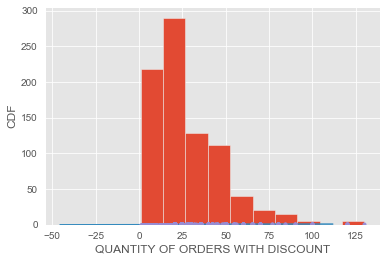

In [25]:
OrderDetail_df_discount = np.array(OrderDetail_df
                        [OrderDetail_df['Discount']!=0]['Quantity'])
x1, y1 = ecdf(OrderDetail_df_discount)
x_theor1, y_theor1 = ecdf(sample_discount)
_=plt.hist(OrderDetail_df_discount)
_=plt.plot(x_theor1, y_theor1)
_=plt.plot(x1,y1, marker = '.', linestyle = 'none')
_=plt.xlabel('QUANTITY OF ORDERS WITH DISCOUNT')
_=plt.ylabel('CDF')
plt.show()

In [26]:
mean_no_disc = np.mean(OrderDetail_df
                       [OrderDetail_df['Discount']==0]['Quantity'])
std_no_disc  =  np.std(OrderDetail_df[OrderDetail_df['Discount']==0]['Quantity'])                  
sample_no_discount = np.random.normal(mean_no_disc, std_no_disc,size = 10000)
print(mean_no_disc)
print(std_no_disc)

21.715261958997722
17.500845477669788


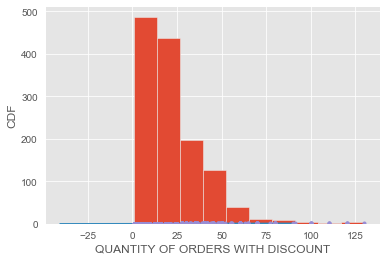

In [27]:
OrderDetail_df_no_discount = np.array(OrderDetail_df
                                      [OrderDetail_df['Discount']==0]['Quantity'])
x2, y2 = ecdf(OrderDetail_df_no_discount)
x_theor2, y_theor2 = ecdf(sample_no_discount)
_=plt.hist(OrderDetail_df_no_discount)
_=plt.plot(x_theor2, y_theor2)
_=plt.plot(x2,y2, marker = '.', linestyle = 'none')
_=plt.xlabel('QUANTITY OF ORDERS WITH DISCOUNT')
_=plt.ylabel('CDF')
plt.show()

#### Conclusion: 
The dataset is not normally distributed therefore we need to use Monte Carlo simulation.

In [28]:
OrderDetail_df.shape

(2155, 7)

In [29]:
OrderDetail_df[OrderDetail_df['Discount']!=0].shape, \
OrderDetail_df[OrderDetail_df['Discount']==0].shape

((838, 7), (1317, 7))

In [30]:
discount_sample = OrderDetail_df.sample(replace = False, 
                        n = len(OrderDetail_df[OrderDetail_df['Discount']!=0]))
discount_sample.shape

(838, 7)

In [31]:
no_discount_sample = OrderDetail_df.drop(discount_sample.index, axis = 0)
no_discount_sample.shape

(1317, 7)

In [32]:
discount_sample.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Discount_code
861,10570/56,10570,56,38.0,60,0.05,D
24,10256/53,10256,53,26.2,15,0.00,N
542,10452/28,10452,28,36.4,15,0.00,N
338,10375/14,10375,14,18.6,15,0.00,N
2059,11046/35,11046,35,18.0,18,0.05,D


### Cohen's d

Cohen's d is an effect size used to indicate the standardised difference between two means. It can be used, for example, to accompany reporting of t-test and ANOVA results. It is also widely used in meta-analysis. Cohen's d is an appropriate effect size for the comparison between two means. d<=0.2 which is considered small effect size, d<=0.5 which is considered medium effect size, d<=0.8 which is considered large effect size.

In [33]:
# Computing Cohen's d function
def Cohen_d(experimental, control):

    diff = experimental.mean() - control.mean()
    n1, n2 = len(experimental), len(control)
    var1 = experimental.var()
    var2 = control.var()
    d = diff / np.sqrt((n1 * var1 + n2 * var2) / (n1 + n2))
    
    return abs(d)


0.0


Text(0.5, 1.0, 'p-value: 0.0')

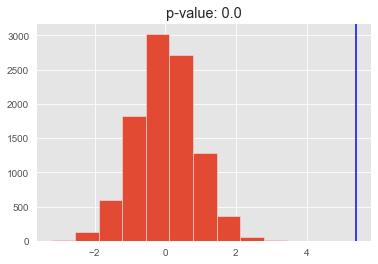

In [34]:
#%%time
mean_diff = OrderDetail_df[OrderDetail_df['Discount']!=0]['Quantity'].mean() -\
               OrderDetail_df[OrderDetail_df['Discount']==0]['Quantity'].mean()
sample_diffs = []
counter = 0
for x in range(10000):
    discount_sample = OrderDetail_df.sample(replace = False,
                      n = len(OrderDetail_df[OrderDetail_df['Discount']!=0]))
    no_discount_sample = OrderDetail_df.drop(discount_sample.index, axis = 0)
    sample_diff = discount_sample['Quantity'].mean() - \
                                        no_discount_sample['Quantity'].mean()
    sample_diffs.append(sample_diff)
    if sample_diff > mean_diff:
        counter += 1
plt.hist(sample_diffs)
plt.axvline(mean_diff, color = 'b')
p = round(counter / 10000, 2)
print(p)
plt.title(f'p-value: {p}')


In [35]:
d = Cohen_d(discount_sample['Quantity'], no_discount_sample['Quantity'])
print('Cohen_d = ', d)

Cohen_d =  0.02583410623707138


#### CONCLUSION:

* The low p-value suggests that the null hypothesis: that the total product quantity of orders with discount less than or equal the total product quantity of orders without discount is false. We reject the null hypothesis due to the p value < 0.05. Which means the product quantity of orders with discount is greater than that with no discount. The Cohen d = 0.037 which is a very small effect size suggests that the difference is not significant.

* The promotion program effect the product quantity of orders

* The following step in the research would be to answer the question about at what discount level we see statisticaly significant difference in orders quantities

* We will follow the same process as previous experiment, but this time we'll break our experimental group into discount levels

### DIFFERENT EFFECT ON PRODUCT QUANTITY OF ORDERS BY DISCOUNT LEVELS

In [36]:
# Each group is a DataFrame containing orders with certain discount level
discounts = OrderDetail_df['Discount'].unique()
groups = {}
for i in discounts:
    groups[i] = OrderDetail_df[OrderDetail_df['Discount']==i]
    groups


In [37]:
# Create new DataFrame with Discounts and Order quantities
discounts_df = pd.DataFrame(columns=['Discount %','Orders','Avg. Order Quantity'])
for i in groups.keys():
    discounts_df = discounts_df.append({'Discount %':i*100,'Orders':len(groups[i]),\
    'Avg. Order Quantity':round(groups[i]['Quantity'].mean(),2)}, ignore_index=True)

discounts_df.T


,0,1,2,3,4,5,6,7,8,9,10
Discount %,0.00,15.00,5.00,20.00,25.00,10.00,2.0,3.00,4.0,6.0,1.0
Orders,1317.00,157.00,185.00,161.00,154.00,173.00,2.0,3.00,1.0,1.0,1.0
Avg. Order Quantity,21.72,28.38,28.01,27.02,28.24,25.24,2.0,1.67,1.0,2.0,2.0


#### CONCLUSION:

At discount levels: 1%, 2%, 3%, 4% and 6% product quantity of orders was really small. Making conclusion on those discount levels will not reflect truly on sales. However, we should do a research to make sure that running those discount level still a need for new product launching or marketing strategy, other while we should stop. Lets drop these discount levels from our experiment.

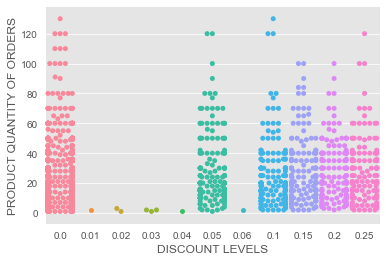

In [38]:
# Make bee swarm plot
_ = sns.swarmplot(x='Discount', y='Quantity', data=OrderDetail_df)
plt.margins = 0.02

# Label axes
_ = plt.xlabel('DISCOUNT LEVELS')
_ = plt.ylabel('PRODUCT QUANTITY OF ORDERS')

# Show the plot
plt.show()

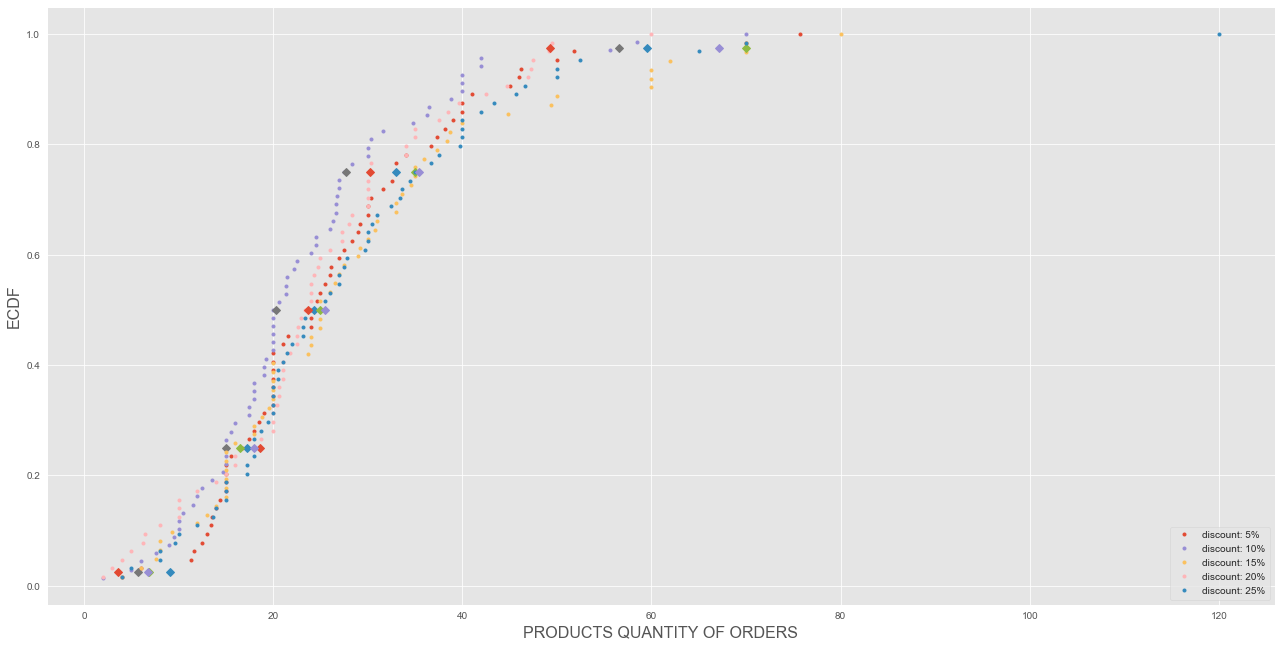

In [39]:
# Create 5 group of discount levels: 5%, 10%, 15%, 20%, 25%
level_table = ['5%', '10%', '15%', '20%', '25%']
discount_levels = [0.05, 0.1, 0.15, 0.2, 0.25]
percentiles = np.array([2.5, 25, 50, 75, 97.5])
plt.figure(figsize=(22,11))
for i in range(len(discount_levels)):
    df = OrderDetail_df[OrderDetail_df['Discount']==discount_levels[i]].\
                        groupby('ProductId')['Quantity'].mean()
    discount = np.array(df)
    x_discount,  y_discount = ecdf(discount)

    # Specify array of percentiles
    ptiles_discount = np.percentile(discount, percentiles)

    # Plot all ECDFs on the same plot:
    _=plt.plot(x_discount, y_discount, marker='.', linestyle='none',\
               label='discount: '+level_table[i])
    _=plt.plot(ptiles_discount, percentiles/100, marker='D', linestyle='none')
    
# Annotate the plot
_=plt.legend(loc='lower right')
_=plt.xlabel('PRODUCTS QUANTITY OF ORDERS', size = 16)
_=plt.ylabel('ECDF', size = 16)
plt.show()

There is difference between product of orders at different discount level but not very clearly. We can't tell any thing. Let's do the Hypothesis test.

### Hypothesis test


Null Hypothesis: there is no difference of product quantity of orders between each discount levels and product quantity of orders with no discount

Alternative Hypothesis: there is difference of product quantity of orders between each discount levels and product quantity of orders with no discount


### Welch's T-test

In statistics, Welch's t-test, or unequal variances t-test, is a two-sample location test which is used to test the hypothesis that two populations have equal means.

In [40]:
# function to perform t-test on two samples
# and compare p-value with provided significant level to reject or not
def perform_ttest(sample1, sample2, significant_level = 0.05):
    # perform t-test to calculate p-value
    st, p = stats.ttest_ind(sample1, sample2)
    
    # calculate Cohen_d
    d = Cohen_d(sample1, sample2)
    
    # compare p-value to reject
    reject = True
    if p >= significant_level:
        reject = False
        
    # return result
    return reject, p, d


# using for calculate cohen_d:
def discount_levels_ttest(discount_level_1, discount_level_2 = 0.0
                                     , significant_level = 0.05):
    # generate sample for discount level 1
    discount_level_1_data = OrderDetail_df[OrderDetail_df['Discount']==discount_level_1]

    # sample for discount level 2
    discount_level_2_data = OrderDetail_df[OrderDetail_df['Discount']==discount_level_2]
    
    # perform t-test and calculate p-value, Cohen_d
    result = perform_ttest(discount_level_1_data['Quantity'], 
                           discount_level_2_data['Quantity'], significant_level)
    
    # return result - (reject, p, d)
    return result

In [41]:
# function to sample data and test the difference of mean to calculate p-value for each pair of discounts
def sample_and_test(discount_level_1, discount_level_2 = 0.0, reps = 10000):
    # calculate the difference of means of each level
    mean_diff = OrderDetail_df[OrderDetail_df['Discount']==discount_level_1]\
                ['Quantity'].mean() - OrderDetail_df[OrderDetail_df
                ['Discount']==discount_level_2]['Quantity'].mean()
    
    # list to store all difference means of all samples
    sample_diffs = []
    
    # count when sample mean difference > original mean difference
    counter = 0
    
    # loop reps times to generate samples
    for x in range(reps):
        # generate sample for discount level 1
        size = len(OrderDetail_df[OrderDetail_df['Discount']==discount_level_1])
        discount_level_1_sample = OrderDetail_df.sample(replace = False, n = size)
        
        # generate supplement sample of sample for discount level 1
        supplement_sample = OrderDetail_df.drop(discount_level_1_sample.index, axis = 0)
        
        # calculate the mean difference of the two samples, and add it to the list
        sample_diff = discount_level_1_sample['Quantity'].mean() - \
                            supplement_sample['Quantity'].mean()
        sample_diffs.append(sample_diff)
        
        # compare same mean difference with original mean difference
        if sample_diff > mean_diff:
            counter += 1
    
    # calculate p-value
    p = round(counter / reps, 2)
    
    # return sample mean difference list and p-value
    return sample_diffs, p

p-value: 0.0
p-value: 0.01
p-value: 0.0
p-value: 0.0
p-value: 0.0


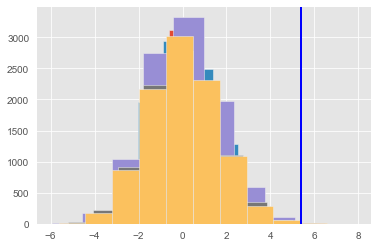

In [42]:
# sample and test for some level of discounts versus no discount
discount_levels = np.array([0.05, 0.1, 0.15, 0.2, 0.25])
for level in discount_levels:
    sample_diffs, p = sample_and_test(level)
    print(f'p-value: {p}')
    plt.hist(sample_diffs)
    plt.axvline(mean_diff, color = 'b')

There is small difference between product quantity of orders with each discount levels and product quantity of orders with no discount.

In [43]:
discounts_sig_df = pd.DataFrame(columns=['Discount %', 'p value',
                    'Null Hypothesis', 'Cohens d'], index=None)
for level in discount_levels:
    result = discount_levels_ttest(level, significant_level=0.05)
    discounts_sig_df = discounts_sig_df.append({'Discount %': 
                    str(level*100)+'%','p value': round(result[1],2),
                    'Null Hypothesis': 'Reject' if result[0] else 'Fail to reject',
                    'Cohens d': round(result[2],2) if result[0] else np.nan}, 
                    ignore_index=True)

discounts_sig_df

,Discount %,p value,Null Hypothesis,Cohens d
0,5.0%,0.00,Reject,0.35
1,10.0%,0.02,Reject,0.20
2,15.0%,0.00,Reject,0.37
3,20.0%,0.00,Reject,0.30
4,25.0%,0.00,Reject,0.37


### CONCLUSION:

* All p-values < 0.05 we reject the null hypothesis. Cohens 0.2 <= d <= 0.5 effect size is small.
* There is difference between product quantity of orders with each discount levels and product quantity of orders with no discount, however the difference is small.

*** Cohen classified effect sizes as small (d  =  0.2), medium (d  =  0.5), and large (d ≥ 0.8)

### Statistically significant difference between discount levels

* Null Hypothesis:

   There is no difference in order quantity between discount levels
   

* Alternative Hypothesis:

   There is a difference in order quantity between discount levels


In [44]:
discount_levels = np.array([0.05, 0.1, 0.15, 0.2, 0.25])
comb = itertools.combinations(discount_levels, 2)
discount_levels_df = pd.DataFrame(columns=['Discount %', 'p value',
                         'Null Hypothesis','Cohens d'], index=None)

for i in comb:
    result = discount_levels_ttest(i[0], i[1], 0.05)  
    discount_levels_df = discount_levels_df.append(
        {'Discount %': str(i[0]*100)+'% vs '+str(i[1]*100)+'%',
         'p value': round(result[1],2),
         'Null Hypothesis': 'Reject' if result[0] else 'Fail to reject',
         'Cohens d': round(result[2],2) if result[0] else np.nan}, ignore_index=True)    

discount_levels_df.sort_values('Cohens d', ascending=False)


,Discount %,p value,Null Hypothesis,Cohens d
0,5.0% vs 10.0%,0.23,Fail to reject,NaN
1,5.0% vs 15.0%,0.87,Fail to reject,NaN
2,5.0% vs 20.0%,0.66,Fail to reject,NaN
3,5.0% vs 25.0%,0.92,Fail to reject,NaN
4,10.0% vs 15.0%,0.18,Fail to reject,NaN
5,10.0% vs 20.0%,0.42,Fail to reject,NaN
6,10.0% vs 25.0%,0.19,Fail to reject,NaN
7,15.0% vs 20.0%,0.54,Fail to reject,NaN
8,15.0% vs 25.0%,0.95,Fail to reject,NaN
9,20.0% vs 25.0%,0.58,Fail to reject,NaN


### CONCLUSION:

* All p-values >0.05 we fail to reject the null hypothesis. 
* Discounts of 5%, 15%, 20% and 25% have approximately the same effect on quantity of orders.

### Next, we want to observe and check if the products of orders each month is difference with the others.

In [45]:
sale_month = pd.read_sql_query('''
                               SELECT O.OrderDate, OD.Quantity, OD.Discount, 
                               CategoryId FROM [Order] AS O
                               JOIN OrderDetail AS OD
                               ON O.Id = OD.OrderId
                               JOIN Product
                               ON Product.Id = OD.ProductId
                            ''',conn)


In [46]:
#sale_month.head(3)
sale_month.OrderDate = pd.to_datetime(sale_month.OrderDate)
sale_month['Month'] = sale_month.OrderDate.dt.month
sale_by_month_df = round(sale_month.groupby('Month').mean(),2)
sale_by_month_df.drop(columns=['Discount', 'CategoryId'], inplace=True)
sale_by_month_df.reset_index(inplace=True)
sale_by_month_df.T

,0,1,2,3,4,5,6,7,8,9,10,11
Month,1.00,2.0,3.00,4.00,5.0,6.00,7.00,8.0,9.00,10.00,11.00,12.00
Quantity,24.76,26.1,22.88,25.26,19.9,21.51,25.85,20.8,22.81,24.68,23.17,25.04


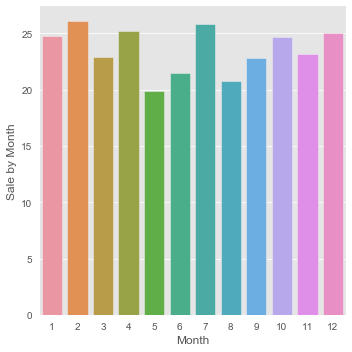

In [47]:
chart = sns.catplot(data=sale_by_month_df, x='Month', y='Quantity', kind='bar')
chart.set_ylabels("Sale by Month");

### Hypothesis statement

Null Hypothesis: There is no difference in the product quantity of orders between each month.

Alternative Hypothesis: There is difference in the product quantity of orders between each month.

### ANOVA TEST



In [48]:
formula = 'Quantity ~ C(Month)'
lm = ols(formula, sale_month).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                 sum_sq      df         F    PR(>F)
C(Month)    7395.980026    11.0  1.866405  0.039229
Residual  772003.656168  2143.0       NaN       NaN


### CONCLUSION:

* The p-value = 0.039 < 0.05, we reject null hypothesis. There is statistically significant difference in order quantity between months. 

* Normally, People tend to spend more on holidays, summer time, spring time and even school time, etc. check sales on those special events that suggests that we need to check the promotion program, lauching new products, learning on customer demand, habit or new marketing strategy. We need to change for better sales performance.

### DIFFERENCE BETWEEN THE PRODUCT OF ORDERS BY EMPLOYEE'S SALES PERFORMANCE

### HYPOTHESIS STATEMENT:

* Null Hypothesis: There is no difference between employee sale performance.
* Alternative Hypothesis: There is difference between employee sale performance.


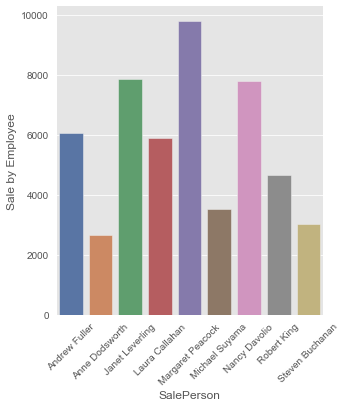

In [49]:
### Loaded data and have done initial EDA above
# RECALL: group employee sale details by employee to calculate sum of sale quantity
#empl_sale_df2 = empl_sale_df.groupby(['SalePerson', 'SalePersonID']).sum()
#empl_sale_df2.drop(columns=['ProductId', 'Discount'], inplace=True)
#empl_sale_df2.reset_index(inplace=True)
#print(empl_sale_df2)

# plot
g = sns.catplot(data=empl_sale_df2, x='SalePerson', y='Quantity', kind="bar", palette = 'deep')
g.set_ylabels("Sale by Employee")
g.set_xticklabels(rotation=45);

In [50]:
empl_sale_df.groupby(['SalePersonID']).mean().T

SalePersonID,1,2,3,4,5,6,7,8,9
ProductId,41.182609,38.958506,42.174455,40.507143,41.675214,41.654762,40.011364,40.865385,39.439252
Discount,0.049246,0.043776,0.049688,0.061310,0.066667,0.054464,0.073580,0.056154,0.068224
Quantity,22.643478,25.124481,24.461059,23.328571,25.948718,20.994048,26.443182,22.742308,24.953271


### ANOVA TEST

In [51]:
formula = 'Quantity ~ C(SalePersonID)'
lm = ols(formula, empl_sale_df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                        sum_sq      df         F   PR(>F)
C(SalePersonID)    4643.183282     8.0  1.607646  0.11745
Residual         774756.452913  2146.0       NaN      NaN


### CONCLUSION:

* The p-value = 0.12 > 0.05, we fail to reject null hypothesis. There is no difference in product quantiy of orders between employees' sales performance. 

* We need to set sales target for employees monthly, quarterly, yearly.
* We need to have recognition rewards for employees who achive the sales target, raise sales commission to encourage employees to improve their sales performance.
* Besides, marketing training is a need also.

### DIFFERENCE BETWEEN PRODUCT QUANTITY OF ORDERS BY CUSTOMER COUNTRIES

### HYPOTHESIS TEST

* Null Hypothesis: There is no difference of mean values between the product quantity of orders by customer country.
* Alternate Hypothesis: there is difference of mean values between the product quantity of orders by customer country.

In [52]:
sale_by_country_df = pd.read_sql_query('''
                                SELECT O.OrderDate, OD.Quantity, 
                                       C.ID AS CustomerID, C.Country
                                FROM [Order] AS O
                                JOIN OrderDetail AS OD ON O.Id = OD.OrderId
                                JOIN Customer AS C ON C.ID=O.CustomerID
                            ''', conn)

country_sale = sale_by_country_df.groupby(['Country']).sum()
pd.options.display.max_columns = None
country_sale.T

Country,Argentina,Austria,Belgium,Brazil,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Mexico,Norway,Poland,Portugal,Spain,Sweden,Switzerland,UK,USA,Venezuela
Quantity,207,5167,1392,3216,1984,1170,885,3174,9213,1684,822,666,161,205,533,718,2235,1275,2742,9330,2936


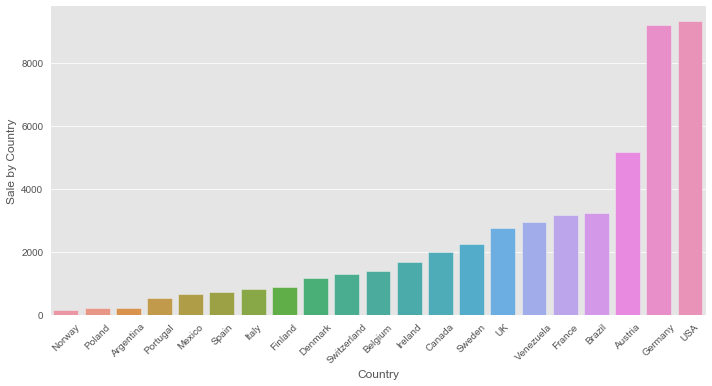

In [53]:
sale_by_country_df1 = sale_by_country_df.groupby(['Country']).sum()
sale_by_country_df1.reset_index(inplace=True)
sale_by_country_df1 = sale_by_country_df1.sort_values(['Quantity'])

chart = sns.catplot(data=sale_by_country_df1, x='Country', y='Quantity', kind='bar', height=5, aspect=2)
chart.set_ylabels("Sale by Country")
chart.set_xticklabels(rotation=45);


### ANOVA TEST

In [54]:
formula = 'Quantity ~ C(Country)'
lm = ols(formula, sale_by_country_df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                   sum_sq      df          F        PR(>F)
C(Country)   91626.751121    20.0  14.061982  1.197549e-44
Residual    670162.386992  2057.0        NaN           NaN


### CONCLUSION:
* The p-value = 1.20 > 0.05, we fail to reject the null hypothesis 
* The sales of each country is not different with other sales of other countries. We need to understand why in order we can increase the sales for next term, next season.

### MORE RESEARCH:

* Compare sales between Employees from US and from UK. 

* We need to check sales on disproduce products

* With the relatively same discount program were given across categories, is there any difference between categories sales

* Research further if clients responded better to discount

* Find out optimal level of discount for products according to their price and possible seasonal demand

* Performance of shipping companies, supply chain management (SCM).